<a href="https://colab.research.google.com/github/jmmzhng-pro/DSCI_631_Project/blob/main/Interest_Rate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **00. System and Environment Setup**

In [ ]:
# Comment in and out as need
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# install packages here
%pip install FedTools

In [ ]:
# import standard modules here
import sys
import os
import datetime
import requests

In [ ]:
# import standard modules with aliases here
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import matplotlib.dates as mdates
import seaborn as sb

In [ ]:
# import non-standard modules / python scripts / objects here
sys.path.append('/content/drive/MyDrive/DSCI 521 Assignments and Project/Project/Final Submission/fomc_get_data')
from FomcStatement import FomcStatement

# **01. Data Acquistion, Pre-Processing, and EDA**

In [ ]:
# this function access stock price data via the yahoo finance api and save it as a csv to to the specified path.
def download_stock_price(myTicker = '^GSPC', start_time='2008-01-01', path = '/content/drive/MyDrive/DSCI 631 Assignments and Project/Project/StockData/All Current S&P 500 Constituents/'):
  myData = yf.Ticker(myTicker).history(start=start_time)
  myData.to_csv(path + myTicker + '.csv')
  return myData

In [ ]:
# this function gets a list of the current S&P 500 constituents from web scrape
def download_s_and_p_500_data (path = '/content/drive/MyDrive/DSCI 631 Assignments and Project/Project/StockData/All Current S&P 500 Constituents/constituents.csv'):
  link = (
    "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies#S&P_500_component_stocks"
  )
  data = pd.read_html(link, header=0)[0]
  data.to_csv(path, index=False)
  return data

In [ ]:
#usage
sp_500_data = download_s_and_p_500_data()

#download price information for each stock
for i, stock in sp_500_data.iterrows():
  download_stock_price(stock['Symbol'])

ERROR:yfinance:BRK.B: No timezone found, symbol may be delisted
ERROR:yfinance:BF.B: No price data found, symbol may be delisted (1d 2008-01-01 -> 2023-12-12)


In [ ]:
#Code for US Treasury API to download interest rate data
api_url = "https://api.fiscaldata.treasury.gov/services/api/fiscal_service/v2/accounting/od/avg_interest_rates"
fields = "?fields=record_date,security_desc,avg_interest_rate_amt"
filters = "&filter=record_date:gte:2008-01-01"
size = "&page[size]=5000"
response = requests.get(api_url+fields+filters+size)
data = response.json()
interest_rate = data.get("data",[])
interest_df = pd.DataFrame(interest_rate)
interest_df_wide = interest_df.pivot(index='record_date', columns='security_desc', values='avg_interest_rate_amt')
interest_df_wide = interest_df_wide.apply(pd.to_numeric)
interest_df_wide.index = pd.to_datetime(interest_df_wide.index)
interest_df_wide.to_csv('/content/drive/MyDrive/DSCI 631 Assignments and Project/Project/Final Project/Datasets/InterestRate/InterestRateSecurities.csv')
interest_df_wide

security_desc,Domestic Series,Federal Financing Bank,Foreign Series,Government Account Series,Government Account Series Inflation Securities,Hope Bonds,R.E.A. Series,Special Purpose Vehicle,State and Local Government Series,Total Interest-bearing Debt,Total Marketable,Total Non-marketable,Treasury Bills,Treasury Bonds,Treasury Floating Rate Notes (FRN),Treasury Inflation-Protected Securities (TIPS),Treasury Notes,United States Savings Inflation Securities,United States Savings Securities
record_date,,,,,,,,,,,,,,,,,,,
2008-01-31,7.941,4.652,4.088,5.004,NaN,NaN,5.0,NaN,4.252,4.785,4.573,4.982,3.528,7.361,NaN,2.463,4.359,1.838,5.657
2008-02-29,7.942,4.652,4.383,4.988,NaN,NaN,5.0,NaN,4.225,4.683,4.390,4.965,3.038,7.294,NaN,2.463,4.328,1.838,5.656
2008-03-31,7.942,4.652,4.670,4.963,NaN,NaN,5.0,NaN,4.179,4.582,4.215,4.940,2.553,7.294,NaN,2.463,4.274,1.834,5.654
2008-04-30,7.942,4.652,4.672,4.955,NaN,NaN,5.0,NaN,4.129,4.560,4.170,4.930,2.262,7.294,NaN,2.412,4.231,1.832,5.651
2008-05-31,7.942,4.652,6.954,4.982,NaN,NaN,5.0,NaN,4.140,4.517,4.057,4.957,1.994,7.252,NaN,2.412,4.235,1.830,5.648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-31,7.577,2.513,0.000,2.707,1.055,NaN,NaN,4.114,2.599,2.841,2.873,2.717,5.219,3.049,5.369,0.575,2.018,5.893,3.196
2023-08-31,7.577,2.513,0.000,2.753,1.055,NaN,NaN,4.172,2.809,2.921,2.962,2.765,5.319,3.045,5.205,0.581,2.077,5.539,3.224
2023-09-30,7.577,2.513,0.000,2.771,1.055,NaN,NaN,4.162,3.089,2.970,3.016,2.787,5.380,3.051,4.979,0.592,2.106,5.194,3.253


In [ ]:
sp500 = download_stock_price('^GSPC')
sp500_close = sp500['Close']
sp500_monthly = sp500.resample('M').mean()
sp500_monthly = sp500_monthly['Close']
sp500_monthly = pd.DataFrame(sp500_monthly)
sp500_monthly.index = sp500_monthly.index.strftime("%Y-%m-%d")
sp500_monthly.index = pd.to_datetime(sp500_monthly.index)
sp500_monthly.to_csv('/content/drive/MyDrive/DSCI 631 Assignments and Project/Project/Final Project/Datasets/StockPrice/GSPC_monthly.csv')

Text(0.5, 0, 'Year')

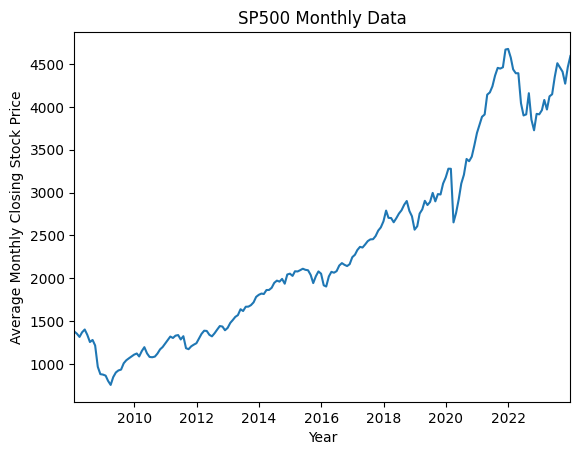

In [ ]:
#Create plot of SP500 from 2008 to 2023
plt.plot(sp500_monthly)
plt.xlim([sp500_monthly.index.min(),sp500_monthly.index.max()])
plt.title("SP500 Monthly Data")
plt.ylabel("Average Monthly Closing Stock Price")
plt.xlabel("Year")

In [ ]:
corr_df = pd.concat([interest_df_wide,sp500_monthly],axis=1)
corr_df

,Domestic Series,Federal Financing Bank,Foreign Series,Government Account Series,Government Account Series Inflation Securities,Hope Bonds,R.E.A. Series,Special Purpose Vehicle,State and Local Government Series,Total Interest-bearing Debt,Total Marketable,Total Non-marketable,Treasury Bills,Treasury Bonds,Treasury Floating Rate Notes (FRN),Treasury Inflation-Protected Securities (TIPS),Treasury Notes,United States Savings Inflation Securities,United States Savings Securities,Close
2008-01-31,7.941,4.652,4.088,5.004,NaN,NaN,5.0,NaN,4.252,4.785,4.573,4.982,3.528,7.361,NaN,2.463,4.359,1.838,5.657,1378.763806
2008-02-29,7.942,4.652,4.383,4.988,NaN,NaN,5.0,NaN,4.225,4.683,4.390,4.965,3.038,7.294,NaN,2.463,4.328,1.838,5.656,1354.872510
2008-03-31,7.942,4.652,4.670,4.963,NaN,NaN,5.0,NaN,4.179,4.582,4.215,4.940,2.553,7.294,NaN,2.463,4.274,1.834,5.654,1316.942993
2008-04-30,7.942,4.652,4.672,4.955,NaN,NaN,5.0,NaN,4.129,4.560,4.170,4.930,2.262,7.294,NaN,2.412,4.231,1.832,5.651,1370.469094
2008-05-31,7.942,4.652,6.954,4.982,NaN,NaN,5.0,NaN,4.140,4.517,4.057,4.957,1.994,7.252,NaN,2.412,4.235,1.830,5.648,1403.217616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31,7.577,2.513,0.000,2.753,1.055,NaN,NaN,4.172,2.809,2.921,2.962,2.765,5.319,3.045,5.205,0.581,2.077,5.539,3.224,4457.358674
2023-09-30,7.577,2.513,0.000,2.771,1.055,NaN,NaN,4.162,3.089,2.970,3.016,2.787,5.380,3.051,4.979,0.592,2.106,5.194,3.253,4409.094995
2023-10-31,7.577,2.513,0.000,2.868,1.137,NaN,NaN,4.162,3.233,3.052,3.096,2.884,5.437,3.070,5.430,0.613,2.190,4.395,3.285,4269.400945
2023-11-30,7.577,2.513,0.000,2.876,1.138,NaN,NaN,4.124,3.352,3.103,3.155,2.894,5.451,3.086,5.144,0.624,2.244,4.490,3.317,4460.063314


Text(0.5, 1.0, 'Correlation Heatmap (Interest Securities vs. SP500 Monthly Stock Price Close)')

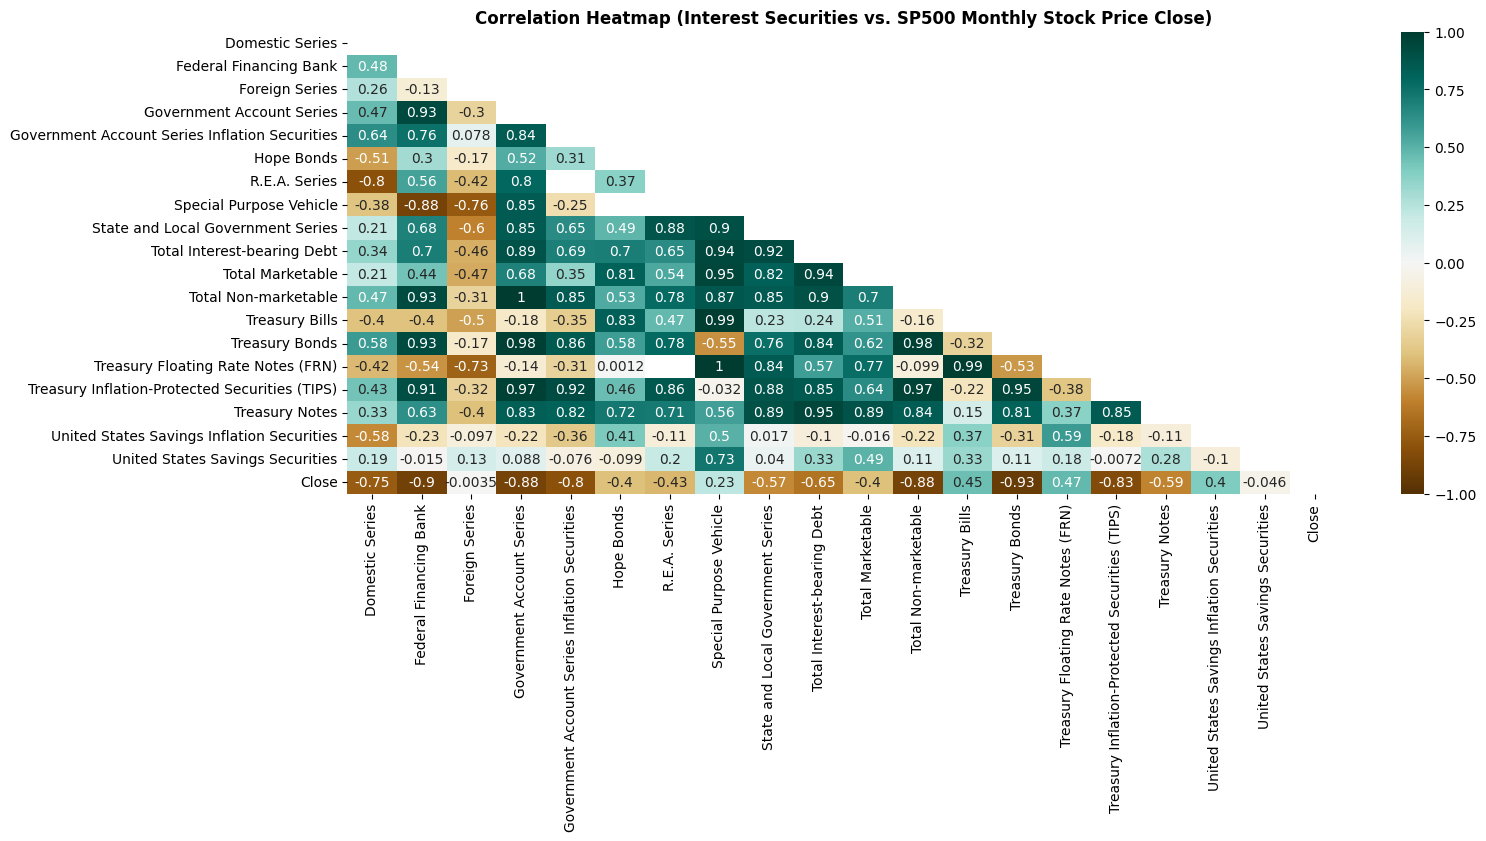

In [ ]:
#Correlation between Interest Securities and SP500 Monthly
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(corr_df.corr(numeric_only = True), dtype=bool))
heatmap = sb.heatmap(corr_df.corr(numeric_only = True), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
plt.title('Correlation Heatmap (Interest Securities vs. SP500 Monthly Stock Price Close)', weight='bold')

In [ ]:
selected_interest_df = interest_df_wide[['Federal Financing Bank','Treasury Bonds','Government Account Series']]
selected_interest_df.to_csv('/content/drive/MyDrive/DSCI 631 Assignments and Project/Project/Final Project/Datasets/InterestRate/SelectedInterestRate.csv')

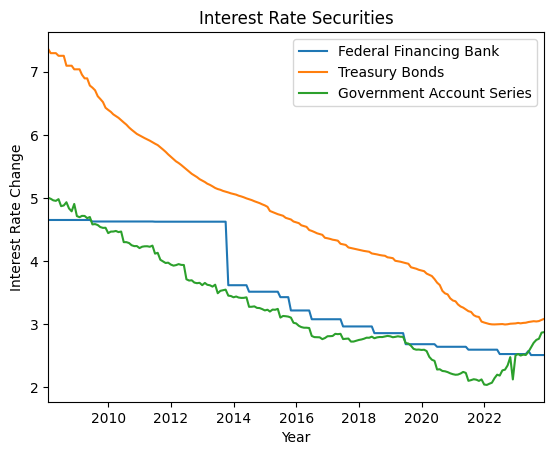

In [ ]:
#Create plot of SP500 from 2008 to 2023
plt.plot(selected_interest_df['Federal Financing Bank'],label='Federal Financing Bank')
plt.plot(selected_interest_df['Treasury Bonds'],label='Treasury Bonds')
plt.plot(selected_interest_df['Government Account Series'],label='Government Account Series')
plt.xlim([selected_interest_df.index.min(),selected_interest_df.index.max()])
plt.title("Interest Rate Securities")
plt.ylabel("Interest Rate Change")
plt.xlabel("Year")
plt.legend()